# Trabalho de TABD

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import psycopg2
import math
import datetime
import csv
import time
from postgis import Polygon,MultiPolygon
from postgis.psycopg import register
import trab_functions as aux
from importlib import reload
from ipywidgets import widgets
from IPython.display import HTML, display

### Definição de variáveis globais e carregar alguns ficheiros

In [115]:
starttime=time.time()

""" Definição de algumas variáveis globais """
ON_THE_FLY=False
DEBUG=True
OFFSETS=[]
OFFSETS_CSV='offsets3.csv'
EPIDEMIC_CSV='epidemic.csv'
DB_NAME='tracks'
DB_USER='nan'


""" Estabelecer uma conexão com a base de dados """

conn = psycopg2.connect("dbname=%s user=%s" % (DB_NAME,DB_USER))
register(conn)
cursor_psql = conn.cursor()

""" Carregar o csv com os offsets """

OFFSETS = aux.read_offsets(OFFSETS_CSV)

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 36.070327 seconds


## Parte 1 - Animar uma simulação criada à priori

### Carregar o csv com a epidemia e calcular os histogramas

In [3]:
starttime=time.time()

""" Ler os dados da epidemia para um array"""
infected= aux.read_csv('epidemic.csv')
infected=np.array(infected)

""" Calcular os histogramas para as diferentes janelas temporais """
histx,histy,histy_ninf = aux.getHistogramData(infected)

if DEBUG: print("took %f seconds" % (time.time()-starttime))

took 44.182038 seconds


In [4]:
#todo mudar isto para o modulo trab_functions
def within(point):
    sql='''
    SELECT concelho FROM cont_aad_caop2018
    WHERE st_within(ST_SetSRID( ST_Point( %f, %f), 3763), proj_boundary)
    ''' % (point[0],point[1])
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    if (not results):
        return "OTHER"
    return str(results[0][0])

hora=0
concelho={}
n_rows=len(OFFSETS)
n_cols=len(OFFSETS[0])
step = int(n_rows/24)
for r in range(0,n_rows,step):
    concelho[hora]=[]
    for c in range(0,n_cols):
        if(OFFSETS[r][c][0]!=0):
            if(infected[r][c]==.2):
                name_concelho=within(OFFSETS[r][c])
                found=False
                for j in range(0,len(concelho[hora])):
                    if(concelho[hora][j][0]==name_concelho):
                        concelho[hora][j][1]+=1
                        found=True
                        break
                if(not found):
                    concelho[hora].append([name_concelho,1])
    print(hora, concelho[hora])
#    r+=int(n_rows/24)
    hora+=1

## filtrar os casos no porto, lisboa e outros
n_porto=[]
n_lisboa=[]
n_others=[]
for hora in concelho:
    count=0
    for c in concelho[hora]:
        if(c[0]=='PORTO'):
            for j in range(0,359):
                n_porto.append(c[1])
        elif(c[0]=='LISBOA'):
            for j in range(0,359):
                n_lisboa.append(c[1])
        else:
            count+=1
    for j in range(0,360):
        n_others.append(count)
    
 #   n_others.append(count)
 
n_porto = np.array(n_porto)
n_lisboa = np.array(n_lisboa)

x_horas=np.array([])
for h in range(0,24):
    tmp=np.linspace(h,h,360)
    x_horas = np.concatenate((x_horas,tmp),axis=None)
print(n_porto)
print(n_lisboa)
print(n_others)

0 []
1 []
2 [['MAIA', 1], ['LISBOA', 2]]
3 [['LISBOA', 11], ['AMADORA', 1]]
4 [['PORTO', 1], ['LISBOA', 36], ['ODIVELAS', 2], ['SINTRA', 1]]
5 [['PORTO', 1], ['ODIVELAS', 3], ['OEIRAS', 2], ['AMADORA', 2], ['LISBOA', 62], ['SINTRA', 5], ['VILA FRANCA DE XIRA', 1]]
6 [['PORTO', 1], ['LOURES', 2], ['LISBOA', 82], ['ODIVELAS', 5], ['OEIRAS', 6], ['SINTRA', 5], ['AMADORA', 6], ['VILA FRANCA DE XIRA', 1]]
7 [['LISBOA', 180], ['ODIVELAS', 25], ['LOURES', 13], ['OEIRAS', 8], ['AMADORA', 6], ['SINTRA', 30], ['CASCAIS', 1], ['VILA FRANCA DE XIRA', 1]]
8 [['PORTO', 10], ['VILA NOVA DE GAIA', 5], ['ODIVELAS', 32], ['LOURES', 21], ['LISBOA', 271], ['AMADORA', 16], ['LOURINHÃ', 1], ['OEIRAS', 38], ['SINTRA', 62], ['CASCAIS', 4], ['SEIXAL', 1], ['VILA FRANCA DE XIRA', 1]]
9 [['PORTO', 142], ['MAIA', 13], ['MATOSINHOS', 28], ['VILA NOVA DE GAIA', 54], ['GONDOMAR', 23], ['VILA DO CONDE', 1], ['VILA NOVA DE FAMALICÃO', 1], ['VALONGO', 1], ['LISBOA', 341], ['ODIVELAS', 40], ['SINTRA', 69], ['AMADORA', 1

## Análise geral da tabela tracks

### Mostrar o numero de taxis

In [5]:
cursor_psql.execute('''
                    SELECT COUNT(DISTINCT taxi) 
                    FROM tracks
                    ''')
results = cursor_psql.fetchall()
n_taxis= int(results[0][0])
n_taxis

1660

### Mostrar numero de trajetos que iniciaram a sua marcha a partir de que distritos

In [225]:
cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_startpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 2 desc
                    '''
)
results  = cursor_psql.fetchall()
#fields = tuple([field[0] for field in cursor_psql.description])
#results.insert(0,fields)

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

LISBOA,47945
PORTO,33835
COIMBRA,14127
BRAGA,4129
AVEIRO,2062
SETÚBAL,134
SANTARÉM,19
FARO,5
VIANA DO CASTELO,4
LEIRIA,1


In [234]:
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
   )
))

LISBOA,47945
PORTO,33835
COIMBRA,14127
BRAGA,4129
AVEIRO,2062
SETÚBAL,134
SANTARÉM,19
FARO,5
VIANA DO CASTELO,4
LEIRIA,1


### Mostrar numero de trajectos que terminaram a sua marcha em que distritos

<IPython.core.display.Javascript object>


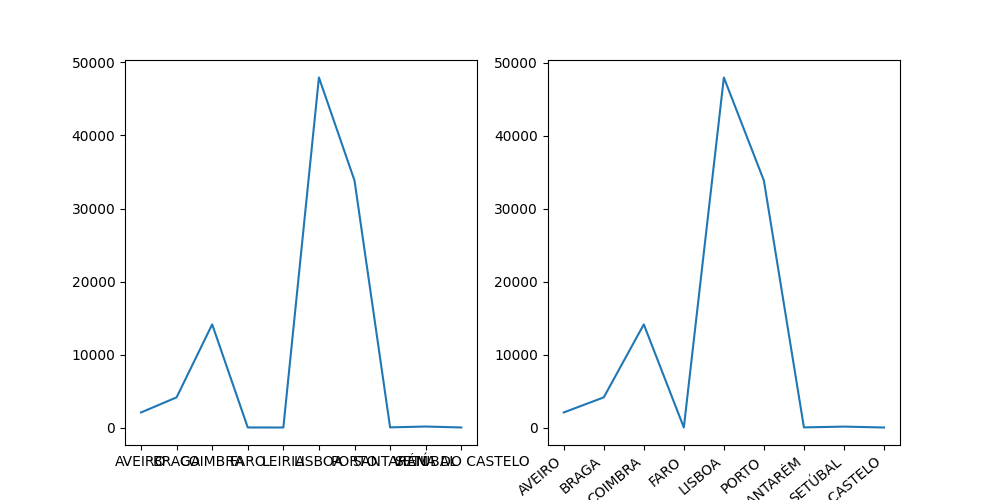

In [104]:
cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_endpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 2 desc
                    '''
)
fields = tuple([field[0] for field in cursor_psql.description])
results  = cursor_psql.fetchall()
results.insert(0,fields)

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

<IPython.core.display.Javascript object>


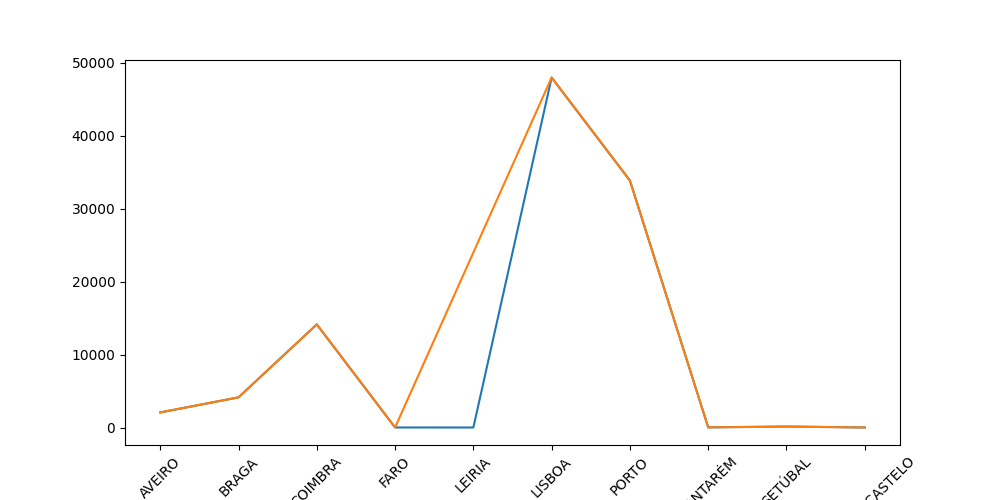

In [110]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(10, 5)


ax1.set_xticklabels(x1, rotation=45)

#ax2.set_xticklabels(x2, rotation=45)

ax1.plot(x1, y1)
ax1.plot(x2, y2)
plt.show()

In [117]:
cursor_psql.execute('''
                    SELECT DISTINCT distrito 
                    FROM cont_aad_caop2018  
                    ORDER BY 1 asc
                    '''
)
results  = cursor_psql.fetchall()
xx = [x[0] for x in results] #distritos distintos

xx

['AVEIRO',
 'BEJA',
 'BRAGA',
 'BRAGANÇA',
 'CASTELO BRANCO',
 'COIMBRA',
 'ÉVORA',
 'FARO',
 'GUARDA',
 'LEIRIA',
 'LISBOA',
 'PORTALEGRE',
 'PORTO',
 'SANTARÉM',
 'SETÚBAL',
 'VIANA DO CASTELO',
 'VILA REAL',
 'VISEU']

In [146]:
cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_startpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 1 asc
                    '''
)
results  = cursor_psql.fetchall()
x1,y1 = [x[0] for x in results], [y[1] for y in results]
yy1=[]
for x in xx:
    yy1.append((x1[x1.index(x)],y1[x1.index(x)])) if x in x1 else yy1.append((x,0))
x1,y1 = [x[0] for x in yy1], [y[1] for y in yy1]


cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_endpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 1 asc
                    '''
)
results  = cursor_psql.fetchall()
x2,y2 = [x[0] for x in results], [y[1] for y in results]
yy2=[]
for x in xx:
    yy2.append((x2[x2.index(x)],y2[x2.index(x)])) if x in x2 else yy2.append((x,0))
x2,y2 = [x[0] for x in yy2], [y[1] for y in yy2]

### Função auxiliar para mostrar os poligonos de cada distrito

In [8]:
def show_map(results,map_plot):
    xs, ys = [],[]
    for row in results:
        geom = row[1]
        if type(geom) is MultiPolygon:
            for pol in geom:
                xys = pol[0].coords
                xs, ys = [],[]
                for (x,y) in xys:
                    xs.append(x)
                    ys.append(y)
                map_plot.plot(xs,ys,color='black',lw='0.2')
        if type(geom) is Polygon:
            xys = geom[0].coords
            xs, ys = [],[]
            for (x,y) in xys:
                xs.append(x)
                ys.append(y)
            map_plot.plot(xs,ys,color='black',lw='0.2')
        

### Mostrar a animação

<IPython.core.display.Javascript object>


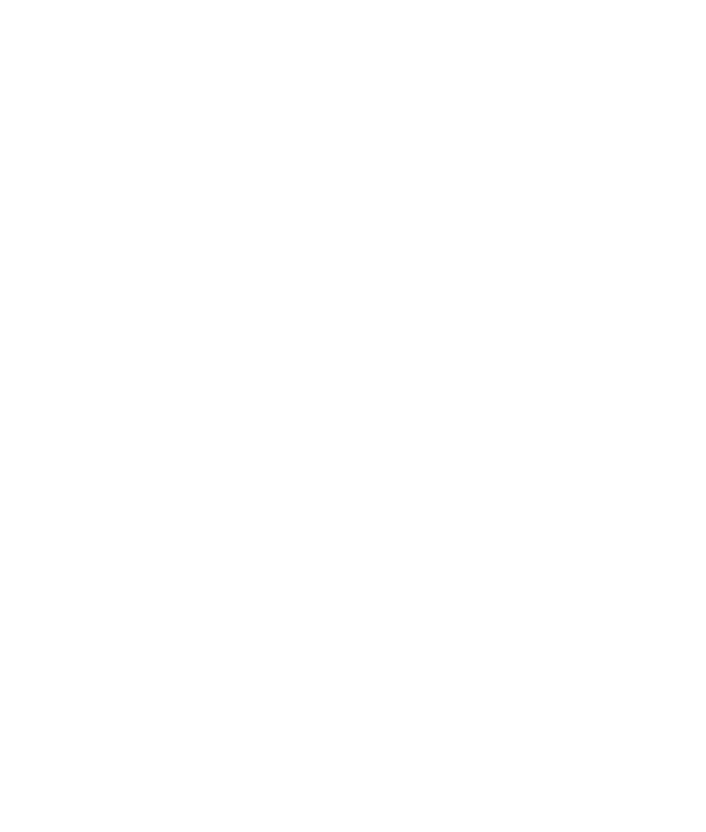

took 28 seconds


In [9]:
%matplotlib notebook

starttime=time.time()

query = '''
        SELECT min(st_xmin(proj_boundary)) as xmin, max(st_xmax(proj_boundary)) as xmax, 
            min(st_ymin(proj_boundary)) as ymin, max(st_ymax(proj_boundary)) as ymax 
        FROM cont_aad_caop2018;
        '''
cursor_psql.execute(query)
results = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][0], results[0][1], results[0][2], results[0][3]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1

scale=1/3000000
ts_i= 1570665600

fig= plt.figure(figsize=(width_in_inches*scale +3 , height_in_inches*scale)) 

gs = gridspec.GridSpec(3, 2)
pt_map1 = plt.subplot(gs[0:3, 0])
pt_map1.axis('off')
pt_map1.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))

portugal1 = plt.subplot(gs[0, 1])
portugal1.set_title("Evolução dos casos em Portugal")

porto = plt.subplot(gs[1, 1])
porto.set_title("Evolução dos casos no Porto")

lisboa = plt.subplot(gs[2, 1])
lisboa.set_title("Evolução dos casos em Lisboa")

fig.add_subplot(pt_map1) 
fig.add_subplot(portugal1) 
fig.add_subplot(porto) 
fig.add_subplot(lisboa)

xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

    
green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

colors1, colors2 = np.full(half,green), np.full(rest,red)
colors = [*colors1,*colors2]    
scat = pt_map1.scatter(xx,yy,c=colors,s=2, cmap=mpl.cm.Set1)

query = '''
            SELECT distrito, st_union(proj_boundary) 
            FROM cont_aad_caop2018 
            GROUP BY distrito
        '''

cursor_psql.execute(query)
results = cursor_psql.fetchall()

show_map(results,pt_map1)


def animate(i, color_data, scat, n_porto, n_lisboa, histx, histy, histy_ninf,x_horas):
    pt_map1.set_title(datetime.datetime.utcfromtimestamp(ts_i+i*10))
    
    if(i%180==0):

        portugal1.plot(histx[i],histy[i],color='red')
        portugal1.plot(histx[i],histy_ninf[i],color='green')
    if(i%360==0): #de hora a hora, nao esta a funcionar direito
        #porto.plot(x_horas[i],n_porto[i],color='blue') 
        #lisboa.plot(x_horas[i],n_lisboa[i],color='orange')
        pass
    scat.set_array(color_data[i])
    scat.set_offsets(OFFSETS[i])

    
anim = FuncAnimation(fig, animate, interval=10, frames=len(OFFSETS)-1, repeat = False, fargs=(infected,scat,n_porto,n_lisboa, histx, histy, histy_ninf, x_horas))

plt.show()

if DEBUG: print("took %d seconds" % (time.time()-starttime))

### Animação da epidemia em diferentes distritos

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

DISTRITO_INPUT=1
a=0
def f(distrito):
    return distrito

#query para obter distritos
query = '''
        SELECT DISTINCT distrito 
        FROM cont_aad_caop2018
        ORDER BY 1 asc
        '''
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
distritos = [d[0] for d in results]

distritos_menu = widgets.Dropdown(value=distritos[0],options=distritos,description='Distrito')
horas_slider = widgets.IntRangeSlider(value=(10, 14), min=0, max=23, step=1, description='Intervalo (h)')
escala_slider = widgets.IntSlider(description='Escala: 1/', value=1800605, min=300000, max=3000000)


widgets.VBox([distritos_menu,horas_slider,escala_slider])

In [11]:
""" Carregar os valores de input """
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value
scale=1/escala_slider.value

Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


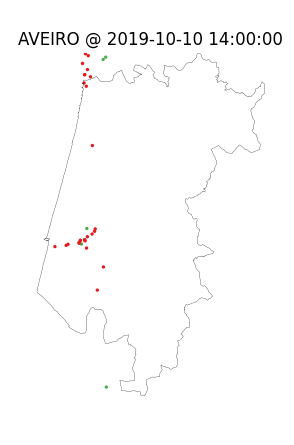

In [12]:
%matplotlib notebook


#Obter o poligono do distrito
query='''
        select 
            distrito, st_union(proj_boundary) as pol, 
            min(st_xmin(proj_boundary)) as xmin, 
            max(st_xmax(proj_boundary)) as xmax, 
            min(st_ymin(proj_boundary)) as ymin, 
            max(st_ymax(proj_boundary)) as ymax 
        from cont_aad_caop2018 where distrito='%s'
        group by distrito
 ''' % distrito


cursor_psql.execute(query)
results  = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][2], results[0][3], results[0][4], results[0][5]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1

ts_hora_i = ts_i+3600*hora_inicial
ts_hora_f = ts_i+3600*hora_final

fig= plt.figure(figsize=(width_in_inches*scale , height_in_inches*scale)) 

gs = gridspec.GridSpec(1, 1)

mapa_distrito = plt.subplot(gs[0, 0])
mapa_distrito.axis('off')
mapa_distrito.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))


fig.add_subplot(mapa_distrito) 

show_map(results,mapa_distrito)

green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

colors1, colors2 = np.full(half,green), np.full(rest,red)

colors = [*colors1,*colors2]

xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

scat = mapa_distrito.scatter(xx,yy,c=colors,s=2, cmap=mpl.cm.Set1)


def animate(i, color_data, scat,ts_hora_i,hora_inicial,hora_final):
    mapa_distrito.set_title(distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+i*10)))

    if(i>=(hora_final-hora_inicial)*360):
        anim.event_source.stop()
    scat.set_array(color_data[i+hora_inicial*360])
    scat.set_offsets(OFFSETS[i+hora_inicial*360])

anim = FuncAnimation(fig, animate, interval=10, frames=len(OFFSETS)-1, repeat = False, fargs=(infected,scat,ts_hora_i,hora_inicial,hora_final))

start_button = widgets.Button(description='Start',disabled=False,button_style='success',icon='play')
pause_button = widgets.Button(description='Pause',disabled=False,button_style='info',icon='pause')
zoom_in_button = widgets.Button(description='Zoom_in',disabled=False,button_style='info',icon='zoom')
zoom_out_button = widgets.Button(description='Zoom_out',disabled=False,button_style='info',icon='zoom')

def event(button):
    anim.event_source.start() if button.description=='Start' else anim.event_source.stop()

def zoom_event(button):
    global scale
    if button.description=="Zoom_in":
        scale+=1/10000000
    else:
        scale-=1/10000000
    fig.set_size_inches(width_in_inches*scale, height_in_inches*scale, forward=True)
   
start_button.on_click(event)
pause_button.on_click(event)
zoom_in_button.on_click(zoom_event)
zoom_out_button.on_click(zoom_event)
widgets.HBox([start_button, pause_button,zoom_in_button, zoom_out_button])




In [114]:
conn.close()

# TODO

- Melhorar/simplificar o código em geral
- verificar se o codigo que gera os histogramas está a funcionar direito
- corrigir os bugs na parte de mostrar os histogramas hora a hora dos infectados no porto e em lisboa
- corrigir as proporções do mapa de portugal
- Corrigir o bug na criação da epidemia - está a considerar taxis noutros concelhos próximos de lisboa ou do porto (ex. Maia) como geradores da epidemia, devem ser apenas taxis do porto ou de lisboa (ler o array com os offsets linha a linha, cada coluna que seja diferente de 0 0 é um taxi que iniciou atividade, fazer uam query com essas coordenadas, se for do porto adicionar [linha,coluna] ao array do porto, se for de lisboa adicionar ao array de lisboa, até que o array do porto fique preenchido com os 10 primeiros taxis e o de lisboa igual)




# Algumas tarefas que me fui lembrando

* Animação dos poligonos à volta dos infectados no porto, em lisboa e no pais. actualizar o gráfico com a área desses poligonos, ou assim
* Animação "on the fly", ir gerando a epidemia e mostrar os dados "em tempo real", com os critérios de distancia e probabilidade de infecao a poderem ser fornecidos pelo utilizador
* Permitir escolher um concelho e ver a animação apenas nesse concelho, assim como o histograma com o numero dos infectados apenas desse concelho
* Incorporar dados do google maps
* Simular uma epidemia em que após x tempo os taxis recuperam, tornam-se imunes, deixam de contaminar e mudam para outra cor. adicionar ao histograma o numero de recuperados